In [1]:
import re
import nltk
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

e:\Python39\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


# Input Data

In [2]:
data = pd.read_excel('dataset.xlsx')
data_input = data
display(data_input)

,No,text,Sentimen
0,1,"Kebijakan nya keren sekali, mahasiswa akan sia...",positif
1,2,halo minsaya sudah kirim email ke kaprodi utk ...,negatif
2,3,Kampus merdeka persaingannya lebih kejam darip...,negatif
3,4,karena hari ini udah Februari makanya udah ga ...,negatif
4,5,Ngerti gasi aing ngundurin diri dari Magang di...,negatif
...,...,...,...
353,341,sebagai anak teknik jadi mulai kebayang gimana...,positif
354,342,semoga magang kampus merdeka gk dijadiin saran...,negatif
355,343,"menarik banget pengen ikutan kampus merdeka, a...",positif
356,344,lumayan dapet uang saku dari magang kampus mer...,positif


# Preprocessing Data

In [3]:
def filteringText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text) 
    text = re.sub(r'[0-9]+', '', text) 
    text = text.replace('\n', ' ') 
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = text.strip(' ') 
    return text

def casefoldingText(text): 
    text = text.lower() 
    return text

def tokenizingText(text): 
    text = word_tokenize(text) 
    return text
    
slangWord = pd.read_excel('kata_alay.xlsx')

slangWord_dict = {}

for index, row in slangWord.iterrows():
    if row[0] not in slangWord_dict:
        slangWord_dict[row[0]] = row[1]
        
def slangWordText(text):
    text = [slangWord_dict[term] if term in slangWord_dict else term for term in text]
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def stopwordRemovalText(text): 
    factory = StopWordRemoverFactory()
    stopword = factory.get_stop_words()
    kata = ['sih', 'ya', 'hahaha', 'terus', 'tt', 'jadi', 'lah', 'gue', 'dulu', 'kok', 'an', 'nya', 'e','wkwkw','minsaya']
    stopword.extend(kata)
    text = [word for word in text if word not in stopword]
    return text

# Cleaning

In [4]:
data['preprocessing'] = data['text'].apply(filteringText)
data_filtering = data

data_filtering

,No,text,Sentimen,preprocessing
0,1,"Kebijakan nya keren sekali, mahasiswa akan sia...",positif,Kebijakan nya keren sekali mahasiswa akan siap...
1,2,halo minsaya sudah kirim email ke kaprodi utk ...,negatif,halo minsaya sudah kirim email ke kaprodi utk ...
2,3,Kampus merdeka persaingannya lebih kejam darip...,negatif,Kampus merdeka persaingannya lebih kejam darip...
3,4,karena hari ini udah Februari makanya udah ga ...,negatif,karena hari ini udah Februari makanya udah ga ...
4,5,Ngerti gasi aing ngundurin diri dari Magang di...,negatif,Ngerti gasi aing ngundurin diri dari Magang di...
...,...,...,...,...
353,341,sebagai anak teknik jadi mulai kebayang gimana...,positif,sebagai anak teknik jadi mulai kebayang gimana...
354,342,semoga magang kampus merdeka gk dijadiin saran...,negatif,semoga magang kampus merdeka gk dijadiin saran...
355,343,"menarik banget pengen ikutan kampus merdeka, a...",positif,menarik banget pengen ikutan kampus merdeka an...
356,344,lumayan dapet uang saku dari magang kampus mer...,positif,lumayan dapet uang saku dari magang kampus mer...


# Case Folding

In [5]:
data['preprocessing'] = data['preprocessing'].apply(casefoldingText)
data_casefolding = data

data_casefolding

,No,text,Sentimen,preprocessing
0,1,"Kebijakan nya keren sekali, mahasiswa akan sia...",positif,kebijakan nya keren sekali mahasiswa akan siap...
1,2,halo minsaya sudah kirim email ke kaprodi utk ...,negatif,halo minsaya sudah kirim email ke kaprodi utk ...
2,3,Kampus merdeka persaingannya lebih kejam darip...,negatif,kampus merdeka persaingannya lebih kejam darip...
3,4,karena hari ini udah Februari makanya udah ga ...,negatif,karena hari ini udah februari makanya udah ga ...
4,5,Ngerti gasi aing ngundurin diri dari Magang di...,negatif,ngerti gasi aing ngundurin diri dari magang di...
...,...,...,...,...
353,341,sebagai anak teknik jadi mulai kebayang gimana...,positif,sebagai anak teknik jadi mulai kebayang gimana...
354,342,semoga magang kampus merdeka gk dijadiin saran...,negatif,semoga magang kampus merdeka gk dijadiin saran...
355,343,"menarik banget pengen ikutan kampus merdeka, a...",positif,menarik banget pengen ikutan kampus merdeka an...
356,344,lumayan dapet uang saku dari magang kampus mer...,positif,lumayan dapet uang saku dari magang kampus mer...


# Tokenization

In [6]:
data['preprocessing'] = data['preprocessing'].apply(tokenizingText)
data_tokenizing = data

data_tokenizing

,No,text,Sentimen,preprocessing
0,1,"Kebijakan nya keren sekali, mahasiswa akan sia...",positif,"[kebijakan, nya, keren, sekali, mahasiswa, aka..."
1,2,halo minsaya sudah kirim email ke kaprodi utk ...,negatif,"[halo, minsaya, sudah, kirim, email, ke, kapro..."
2,3,Kampus merdeka persaingannya lebih kejam darip...,negatif,"[kampus, merdeka, persaingannya, lebih, kejam,..."
3,4,karena hari ini udah Februari makanya udah ga ...,negatif,"[karena, hari, ini, udah, februari, makanya, u..."
4,5,Ngerti gasi aing ngundurin diri dari Magang di...,negatif,"[ngerti, gasi, aing, ngundurin, diri, dari, ma..."
...,...,...,...,...
353,341,sebagai anak teknik jadi mulai kebayang gimana...,positif,"[sebagai, anak, teknik, jadi, mulai, kebayang,..."
354,342,semoga magang kampus merdeka gk dijadiin saran...,negatif,"[semoga, magang, kampus, merdeka, gk, dijadiin..."
355,343,"menarik banget pengen ikutan kampus merdeka, a...",positif,"[menarik, banget, pengen, ikutan, kampus, merd..."
356,344,lumayan dapet uang saku dari magang kampus mer...,positif,"[lumayan, dapet, uang, saku, dari, magang, kam..."


# Normalization

In [7]:
data['preprocessing'] = data['preprocessing'].apply(slangWordText)
data_normalization = data

data_normalization

,No,text,Sentimen,preprocessing
0,1,"Kebijakan nya keren sekali, mahasiswa akan sia...",positif,"[kebijakan, nya, keren, sekali, mahasiswa, aka..."
1,2,halo minsaya sudah kirim email ke kaprodi utk ...,negatif,"[halo, saya, sudah, kirim, email, ke, kaprodi,..."
2,3,Kampus merdeka persaingannya lebih kejam darip...,negatif,"[kampus, merdeka, persaingannya, lebih, kejam,..."
3,4,karena hari ini udah Februari makanya udah ga ...,negatif,"[karena, hari, ini, sudah, februari, makanya, ..."
4,5,Ngerti gasi aing ngundurin diri dari Magang di...,negatif,"[mengerti, engga, saya, ngundurin, diri, dari,..."
...,...,...,...,...
353,341,sebagai anak teknik jadi mulai kebayang gimana...,positif,"[sebagai, anak, teknik, jadi, mulai, terbayang..."
354,342,semoga magang kampus merdeka gk dijadiin saran...,negatif,"[semoga, magang, kampus, merdeka, enggak, dija..."
355,343,"menarik banget pengen ikutan kampus merdeka, a...",positif,"[menarik, banget, pengin, ikutan, kampus, merd..."
356,344,lumayan dapet uang saku dari magang kampus mer...,positif,"[lumayan, dapat, uang, saku, dari, magang, kam..."


# Stopwords removal (Filtering)

In [8]:
data['preprocessing'] = data['preprocessing'].apply(stopwordRemovalText)
data_stopwordRemoval = data

data_stopwordRemoval

,No,text,Sentimen,preprocessing
0,1,"Kebijakan nya keren sekali, mahasiswa akan sia...",positif,"[kebijakan, keren, mahasiswa, pakai, lapangan,..."
1,2,halo minsaya sudah kirim email ke kaprodi utk ...,negatif,"[kirim, email, kaprodi, ttd, surat, sptjm, kam..."
2,3,Kampus merdeka persaingannya lebih kejam darip...,negatif,"[kampus, merdeka, persaingannya, kejam, sbmptn]"
3,4,karena hari ini udah Februari makanya udah ga ...,negatif,"[februari, sedi, sedi, sok, god, have, plan, f..."
4,5,Ngerti gasi aing ngundurin diri dari Magang di...,negatif,"[mengerti, engga, ngundurin, magang, kampus, m..."
...,...,...,...,...
353,341,sebagai anak teknik jadi mulai kebayang gimana...,positif,"[anak, teknik, terbayang, dunia, ikutan, kampu..."
354,342,semoga magang kampus merdeka gk dijadiin saran...,negatif,"[semoga, magang, kampus, merdeka, dijadikan, s..."
355,343,"menarik banget pengen ikutan kampus merdeka, a...",positif,"[menarik, banget, pengin, ikutan, kampus, merd..."
356,344,lumayan dapet uang saku dari magang kampus mer...,positif,"[lumayan, uang, saku, magang, kampus, merdeka,..."


# Stemming

In [9]:
data['preprocessing'] = data['preprocessing'].apply(stemmingText)
data_stemming = data

data_stemming

,No,text,Sentimen,preprocessing
0,1,"Kebijakan nya keren sekali, mahasiswa akan sia...",positif,"[bijak, keren, mahasiswa, pakai, lapang, kerja]"
1,2,halo minsaya sudah kirim email ke kaprodi utk ...,negatif,"[kirim, email, kaprodi, ttd, surat, sptjm, kam..."
2,3,Kampus merdeka persaingannya lebih kejam darip...,negatif,"[kampus, merdeka, saing, kejam, sbmptn]"
3,4,karena hari ini udah Februari makanya udah ga ...,negatif,"[februari, sedi, sedi, sok, god, have, plan, f..."
4,5,Ngerti gasi aing ngundurin diri dari Magang di...,negatif,"[erti, engga, ngundurin, magang, kampus, merde..."
...,...,...,...,...
353,341,sebagai anak teknik jadi mulai kebayang gimana...,positif,"[anak, teknik, bayang, dunia, ikut, kampus, me..."
354,342,semoga magang kampus merdeka gk dijadiin saran...,negatif,"[moga, magang, kampus, merdeka, jadi, sarana, ..."
355,343,"menarik banget pengen ikutan kampus merdeka, a...",positif,"[tarik, banget, pengin, ikut, kampus, merdeka,..."
356,344,lumayan dapet uang saku dari magang kampus mer...,positif,"[lumayan, uang, saku, magang, kampus, merdeka,..."


# Latent Dirichlet Allocation

In [50]:
doc_clean = data['preprocessing']

dictionary = corpora.Dictionary(doc_clean)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# Coherence

In [51]:
coherence = []
for k in range(1,11):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary,chunksize=345,passes=50,iterations=200)
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=doc_clean,dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10


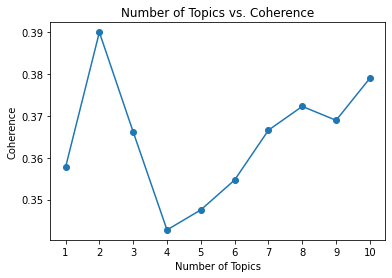

In [52]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

In [53]:
print(coherence)

[(1, 0.35771281915044834), (2, 0.3899903013452971), (3, 0.36617621578602577), (4, 0.34274567627598285), (5, 0.3475330693078883), (6, 0.35467716433427393), (7, 0.36658587293738915), (8, 0.37227032575803487), (9, 0.36893911143193026), (10, 0.37900968000979673)]


In [81]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

total_topics = 2 # jumlah topik yang akan di extract
number_words = 10 # jumlah kata per topik

# Running and Training LDA model on the document term matrix.
lda_model = Lda(doc_term_matrix, num_topics=total_topics, id2word = dictionary,chunksize=345,passes=50,iterations=200)

# Word Count of Topic Keywords

from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in doc_clean for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_imp_wcount = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count']) 
#df_imp_wcount

#Dominant topic and its percentage contribution in each topic
document = data['preprocessing']

def format_topics_sentences(ldamodel=None, corpus=doc_term_matrix, texts=document):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
    
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=doc_clean)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

pyLDAvis.enable_notebook()
topic_data =  gensimvis.prepare(lda_model, doc_term_matrix, dictionary, mds = 'pcoa')

dataLDA = data['aspek'] = df_dominant_topic['Dominant_Topic']

data_LDA = data

In [82]:
print(data['aspek'].value_counts())

0    240
1    118
Name: aspek, dtype: int64


In [83]:
all_topics = {}
lambd = 0.5  # Adjust this accordingly
for i in range(1, total_topics+1): #Adjust number of topics in final model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)]
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:10].values
   
pd.DataFrame(all_topics)

,Topic 1,Topic 2
0,merdeka,merdeka
1,kampus,program
2,magang,kampus
3,banget,laksana
4,ikut,manusia
5,kalo,kuliah
6,dunia,duit
7,anak,pikir
8,skripsi,sulit
9,terap,hasil


In [99]:
perplexity = lda_model.log_perplexity(doc_term_matrix)
print(perplexity)

-6.865280690695776


In [84]:
data['aspek'] = data['aspek'].map({ 0 :'magang kampus merdeka', 1 :'program kampus merdeka'},na_action=None)

display(data_LDA)

,No,text,Sentimen,preprocessing,aspek,aspek_sentimen
0,1,"Kebijakan nya keren sekali, mahasiswa akan sia...",positif,"[bijak, keren, mahasiswa, pakai, lapang, kerja]",magang kampus merdeka,kampus merdeka positif
1,2,halo minsaya sudah kirim email ke kaprodi utk ...,negatif,"[kirim, email, kaprodi, ttd, surat, sptjm, kam...",program kampus merdeka,kampus merdeka negatif
2,3,Kampus merdeka persaingannya lebih kejam darip...,negatif,"[kampus, merdeka, saing, kejam, sbmptn]",magang kampus merdeka,magang mbkm negatif
3,4,karena hari ini udah Februari makanya udah ga ...,negatif,"[februari, sedi, sedi, sok, god, have, plan, f...",magang kampus merdeka,kampus merdeka negatif
4,5,Ngerti gasi aing ngundurin diri dari Magang di...,negatif,"[erti, engga, ngundurin, magang, kampus, merde...",magang kampus merdeka,kampus merdeka negatif
...,...,...,...,...,...,...
353,341,sebagai anak teknik jadi mulai kebayang gimana...,positif,"[anak, teknik, bayang, dunia, ikut, kampus, me...",magang kampus merdeka,magang mbkm positif
354,342,semoga magang kampus merdeka gk dijadiin saran...,negatif,"[moga, magang, kampus, merdeka, jadi, sarana, ...",magang kampus merdeka,magang mbkm negatif
355,343,"menarik banget pengen ikutan kampus merdeka, a...",positif,"[tarik, banget, pengin, ikut, kampus, merdeka,...",magang kampus merdeka,magang mbkm positif
356,344,lumayan dapet uang saku dari magang kampus mer...,positif,"[lumayan, uang, saku, magang, kampus, merdeka,...",magang kampus merdeka,magang mbkm positif


In [85]:
data_LDA['aspek_sentimen'] = data_LDA['aspek'] + " " + data_LDA['Sentimen']

# data_LDA.to_excel("HasilAspek1.xlsx")
display(data_LDA)

,No,text,Sentimen,preprocessing,aspek,aspek_sentimen
0,1,"Kebijakan nya keren sekali, mahasiswa akan sia...",positif,"[bijak, keren, mahasiswa, pakai, lapang, kerja]",magang kampus merdeka,magang kampus merdeka positif
1,2,halo minsaya sudah kirim email ke kaprodi utk ...,negatif,"[kirim, email, kaprodi, ttd, surat, sptjm, kam...",program kampus merdeka,program kampus merdeka negatif
2,3,Kampus merdeka persaingannya lebih kejam darip...,negatif,"[kampus, merdeka, saing, kejam, sbmptn]",magang kampus merdeka,magang kampus merdeka negatif
3,4,karena hari ini udah Februari makanya udah ga ...,negatif,"[februari, sedi, sedi, sok, god, have, plan, f...",magang kampus merdeka,magang kampus merdeka negatif
4,5,Ngerti gasi aing ngundurin diri dari Magang di...,negatif,"[erti, engga, ngundurin, magang, kampus, merde...",magang kampus merdeka,magang kampus merdeka negatif
...,...,...,...,...,...,...
353,341,sebagai anak teknik jadi mulai kebayang gimana...,positif,"[anak, teknik, bayang, dunia, ikut, kampus, me...",magang kampus merdeka,magang kampus merdeka positif
354,342,semoga magang kampus merdeka gk dijadiin saran...,negatif,"[moga, magang, kampus, merdeka, jadi, sarana, ...",magang kampus merdeka,magang kampus merdeka negatif
355,343,"menarik banget pengen ikutan kampus merdeka, a...",positif,"[tarik, banget, pengin, ikut, kampus, merdeka,...",magang kampus merdeka,magang kampus merdeka positif
356,344,lumayan dapet uang saku dari magang kampus mer...,positif,"[lumayan, uang, saku, magang, kampus, merdeka,...",magang kampus merdeka,magang kampus merdeka positif


In [86]:
data1 = pd.read_excel('HasilAspek1.xlsx')

In [87]:
aspek_magang = data1[data1['aspek'] == 'magang kampus merdeka']
aspek_kampus = data1[data1['aspek'] == 'program kampus merdeka']

In [88]:
display(aspek_magang)

,Unnamed: 0,No,text,Sentimen,preprocessing,aspek,aspek_sentimen,clean
0,0,1,"Kebijakan nya keren sekali, mahasiswa akan sia...",positif,"['bijak', 'keren', 'mahasiswa', 'pakai', 'lapa...",magang kampus merdeka,magang kampus merdeka positif,bijak keren mahasiswa pakai lapang kerja
2,2,3,Kampus merdeka persaingannya lebih kejam darip...,negatif,"['kampus', 'merdeka', 'saing', 'kejam', 'sbmptn']",magang kampus merdeka,magang kampus merdeka negatif,kampus merdeka saing kejam sbmptn
3,3,4,karena hari ini udah Februari makanya udah ga ...,negatif,"['februari', 'sedi', 'sedi', 'sok', 'god', 'ha...",magang kampus merdeka,magang kampus merdeka negatif,februari sedi sedi sok god have plan for me ma...
4,4,5,Ngerti gasi aing ngundurin diri dari Magang di...,negatif,"['erti', 'engga', 'ngundurin', 'magang', 'kamp...",magang kampus merdeka,magang kampus merdeka negatif,erti engga ngundurin magang kampus merdeka iis...
5,5,6,"Cukup ayang saja yg ghosting, web kampus merde...",negatif,"['ayang', 'ghosting', 'web', 'kampus', 'merdeka']",magang kampus merdeka,magang kampus merdeka negatif,ayang ghosting web kampus merdeka
...,...,...,...,...,...,...,...,...
352,352,340,Apakah fakultas kedokteran juga menerapkan kam...,negatif,"['fakultas', 'dokter', 'terap', 'kampus', 'mer...",magang kampus merdeka,magang kampus merdeka negatif,fakultas dokter terap kampus merdeka adil kalo...
353,353,341,sebagai anak teknik jadi mulai kebayang gimana...,positif,"['anak', 'teknik', 'bayang', 'dunia', 'ikut', ...",magang kampus merdeka,magang kampus merdeka positif,anak teknik bayang dunia ikut kampus merdeka
354,354,342,semoga magang kampus merdeka gk dijadiin saran...,negatif,"['moga', 'magang', 'kampus', 'merdeka', 'jadi'...",magang kampus merdeka,magang kampus merdeka negatif,moga magang kampus merdeka jadi sarana unikous...
355,355,343,"menarik banget pengen ikutan kampus merdeka, a...",positif,"['tarik', 'banget', 'pengin', 'ikut', 'kampus'...",magang kampus merdeka,magang kampus merdeka positif,tarik banget pengin ikut kampus merdeka andai ...


# Naive Bayes

# Klasifikasi Aspek Sentimen Magang Kampus Merdeka

In [89]:
vectorizer = TfidfVectorizer (max_features=None)
bayes = MultinomialNB()

v_data = vectorizer.fit_transform(aspek_magang['clean']).toarray()

X_train, X_test, y_train, y_test = train_test_split(v_data, aspek_magang['aspek_sentimen'], test_size=0.2)
bayes.fit(X_train,y_train)
bayes.predict(X_test)

array(['magang kampus merdeka negatif', 'magang kampus merdeka negatif',
       'magang kampus merdeka negatif', 'magang kampus merdeka negatif',
       'magang kampus merdeka negatif', 'magang kampus merdeka negatif',
       'magang kampus merdeka negatif', 'magang kampus merdeka negatif',
       'magang kampus merdeka negatif', 'magang kampus merdeka negatif',
       'magang kampus merdeka negatif', 'magang kampus merdeka negatif',
       'magang kampus merdeka negatif', 'magang kampus merdeka negatif',
       'magang kampus merdeka negatif', 'magang kampus merdeka negatif',
       'magang kampus merdeka negatif', 'magang kampus merdeka negatif',
       'magang kampus merdeka negatif', 'magang kampus merdeka negatif',
       'magang kampus merdeka negatif', 'magang kampus merdeka negatif',
       'magang kampus merdeka negatif', 'magang kampus merdeka negatif',
       'magang kampus merdeka negatif', 'magang kampus merdeka negatif',
       'magang kampus merdeka negatif', 'magang kam

In [90]:
display(v_data)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [91]:
print(X_train.shape)
print(X_test.shape)

(192, 924)
(48, 924)


# Confusion Matrix
# Akurasi untuk Sentimen Aspek Magang Kampus Merdeka

In [92]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_preds = bayes.predict(X_test)

print(classification_report(y_test,y_preds))
print('nilai akurasinya adalah ',accuracy_score(y_test, y_preds))

                               precision    recall  f1-score   support

magang kampus merdeka negatif       0.74      1.00      0.85        34
magang kampus merdeka positif       1.00      0.14      0.25        14

                     accuracy                           0.75        48
                    macro avg       0.87      0.57      0.55        48
                 weighted avg       0.82      0.75      0.67        48

nilai akurasinya adalah  0.75


In [93]:
conf = confusion_matrix(y_test, y_preds)
conf

array([[34,  0],
       [12,  2]], dtype=int64)

In [94]:
display(aspek_magang)

,Unnamed: 0,No,text,Sentimen,preprocessing,aspek,aspek_sentimen,clean
0,0,1,"Kebijakan nya keren sekali, mahasiswa akan sia...",positif,"['bijak', 'keren', 'mahasiswa', 'pakai', 'lapa...",magang kampus merdeka,magang kampus merdeka positif,bijak keren mahasiswa pakai lapang kerja
2,2,3,Kampus merdeka persaingannya lebih kejam darip...,negatif,"['kampus', 'merdeka', 'saing', 'kejam', 'sbmptn']",magang kampus merdeka,magang kampus merdeka negatif,kampus merdeka saing kejam sbmptn
3,3,4,karena hari ini udah Februari makanya udah ga ...,negatif,"['februari', 'sedi', 'sedi', 'sok', 'god', 'ha...",magang kampus merdeka,magang kampus merdeka negatif,februari sedi sedi sok god have plan for me ma...
4,4,5,Ngerti gasi aing ngundurin diri dari Magang di...,negatif,"['erti', 'engga', 'ngundurin', 'magang', 'kamp...",magang kampus merdeka,magang kampus merdeka negatif,erti engga ngundurin magang kampus merdeka iis...
5,5,6,"Cukup ayang saja yg ghosting, web kampus merde...",negatif,"['ayang', 'ghosting', 'web', 'kampus', 'merdeka']",magang kampus merdeka,magang kampus merdeka negatif,ayang ghosting web kampus merdeka
...,...,...,...,...,...,...,...,...
352,352,340,Apakah fakultas kedokteran juga menerapkan kam...,negatif,"['fakultas', 'dokter', 'terap', 'kampus', 'mer...",magang kampus merdeka,magang kampus merdeka negatif,fakultas dokter terap kampus merdeka adil kalo...
353,353,341,sebagai anak teknik jadi mulai kebayang gimana...,positif,"['anak', 'teknik', 'bayang', 'dunia', 'ikut', ...",magang kampus merdeka,magang kampus merdeka positif,anak teknik bayang dunia ikut kampus merdeka
354,354,342,semoga magang kampus merdeka gk dijadiin saran...,negatif,"['moga', 'magang', 'kampus', 'merdeka', 'jadi'...",magang kampus merdeka,magang kampus merdeka negatif,moga magang kampus merdeka jadi sarana unikous...
355,355,343,"menarik banget pengen ikutan kampus merdeka, a...",positif,"['tarik', 'banget', 'pengin', 'ikut', 'kampus'...",magang kampus merdeka,magang kampus merdeka positif,tarik banget pengin ikut kampus merdeka andai ...


# Klasifikasi Aspek Sentimen Program Kampus Merdeka

In [95]:
vectorizer = TfidfVectorizer (max_features=None)
bayes = MultinomialNB()

v_data = vectorizer.fit_transform(aspek_kampus['clean']).toarray()

X_train, X_test, y_train, y_test = train_test_split(v_data, aspek_kampus['aspek_sentimen'], test_size=0.2)
bayes.fit(X_train,y_train)
bayes.predict(X_test)

array(['program kampus merdeka negatif', 'program kampus merdeka negatif',
       'program kampus merdeka positif', 'program kampus merdeka positif',
       'program kampus merdeka negatif', 'program kampus merdeka negatif',
       'program kampus merdeka negatif', 'program kampus merdeka negatif',
       'program kampus merdeka negatif', 'program kampus merdeka negatif',
       'program kampus merdeka negatif', 'program kampus merdeka negatif',
       'program kampus merdeka positif', 'program kampus merdeka negatif',
       'program kampus merdeka positif', 'program kampus merdeka negatif',
       'program kampus merdeka negatif', 'program kampus merdeka negatif',
       'program kampus merdeka negatif', 'program kampus merdeka negatif',
       'program kampus merdeka negatif', 'program kampus merdeka negatif',
       'program kampus merdeka negatif', 'program kampus merdeka negatif'],
      dtype='<U30')

In [96]:
print(X_train.shape)
print(X_test.shape)

(94, 675)
(24, 675)


# Confusion Matriks untuk Akurasi Sentimen Aspek Program Kampus Merdeka

In [97]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_preds = bayes.predict(X_test)

print(classification_report(y_test,y_preds))
print('nilai akurasinya adalah ',accuracy_score(y_test, y_preds))

                                precision    recall  f1-score   support

program kampus merdeka negatif       0.75      1.00      0.86        15
program kampus merdeka positif       1.00      0.44      0.62         9

                      accuracy                           0.79        24
                     macro avg       0.88      0.72      0.74        24
                  weighted avg       0.84      0.79      0.77        24

nilai akurasinya adalah  0.7916666666666666


In [98]:
conf = confusion_matrix(y_test, y_preds)
conf

array([[15,  0],
       [ 5,  4]], dtype=int64)